<a href="https://colab.research.google.com/github/sayakpaul/Adversarial-Examples-in-Deep-Learning/blob/master/Adversarial_Training_NSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to:
- Train an image classification model to classify different flower species.
- Create adversarial examples to launch targeted attcks to the classifier.
- Train an adversarially robust classifier using [`Neural Structured Learning`](https://www.tensorflow.org/neural_structured_learning).

We are primarily going to use TensorFlow for this.

## Initial setup

In [1]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
# Which GPU?
!nvidia-smi

Thu Oct  1 02:04:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Other imports
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

# Fix the seeds
SEED = 666
tf.random.set_seed(SEED)
np.random.seed(SEED)

## Flowers dataset

In [4]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

# Specify the class labels, we would need this to create targeted attacks
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


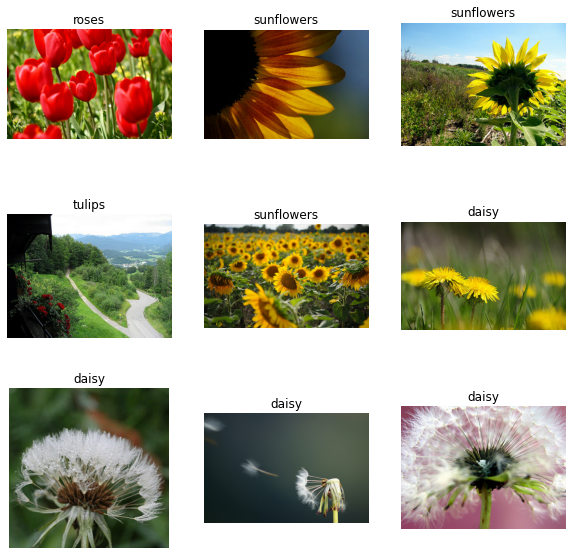

In [5]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[int(label)])
    plt.axis("off")

## Data preparation

In [6]:
# Image preprocessing utils

SIZE = (224, 224)

def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, SIZE)
    return (image, label)

In [7]:
# Construct TensorFlow dataset
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE

# Construct TensorFlow dataset
train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## Model training utilities

In [8]:
def get_training_model(base_model):
    inputs = Input(shape=(224, 224, 3), name="image")
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(5, activation="softmax")(x)
    classifier = Model(inputs=inputs, outputs=x)
    
    return classifier

def plot_progress(hist):
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="validation_loss")
    plt.plot(hist.history["accuracy"], label="training_accuracy")
    plt.plot(hist.history["val_accuracy"], label="validation_accuracy")
    plt.title("Training Progress")
    plt.ylabel("accuracy/loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper left")
    plt.show()

## Model training

In [9]:
# MobileNetV2-based flower classifier
base_model = MobileNetV2(weights="imagenet", include_top=False,
        input_shape=(224, 224, 3))
base_model.trainable = True

get_training_model(base_model).summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


In [11]:
# Define loss function and optimizer
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) # Low since we are fine-tuning

Epoch 1/5
      2/Unknown - 0s 187ms/step - loss: 1.6895 - accuracy: 0.2969WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1013s vs `on_train_batch_end` time: 0.2717s). Check your callbacks.


49/49 [==============================] - 18s 374ms/step - loss: 0.9725 - accuracy: 0.6221 - val_loss: 0.5766 - val_accuracy: 0.8036
Epoch 2/5
49/49 [==============================] - 17s 341ms/step - loss: 0.4476 - accuracy: 0.8452 - val_loss: 0.3964 - val_accuracy: 0.8673
Epoch 3/5
49/49 [==============================] - 17s 340ms/step - loss: 0.3020 - accuracy: 0.9000 - val_loss: 0.3246 - val_accuracy: 0.8818
Epoch 4/5
49/49 [==============================] - 17s 341ms/step - loss: 0.2316 - accuracy: 0.9266 - val_loss: 0.2868 - val_accuracy: 0.9000
Epoch 5/5
49/49 [==============================] - 17s 342ms/step - loss: 0.1789 - accuracy: 0.9449 - val_loss: 0.2607 - val_accuracy: 0.9127
Total training time (seconds):  95.86011552810669


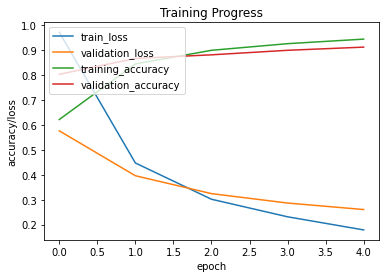

In [12]:
# Train the MobileNetV2-based model
start = time.time()
model_mnv2 = get_training_model(base_model)
model_mnv2.compile(loss=loss_func, optimizer=optimizer, metrics=["accuracy"])
h = model_mnv2.fit(train_ds,
                  validation_data=validation_ds,
                  epochs=5)
print("Total training time (seconds): ",time.time()-start)
plot_progress(h)

## Sample predictions

In [13]:
# Utility to plot sample predictions 
def plot_predictions(images, labels, probability):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image)
        predicted_label = CLASSES[np.argmax(probability[i])]
        maximum_probability = "{:.3f}".format(max(probability[i]))
        text = "{} with probability: {}".format(predicted_label, maximum_probability) + \
            "\nGround-truth: {}".format(CLASSES[int(labels[i])])
        plt.title(text)
        plt.axis("off")
    plt.show()

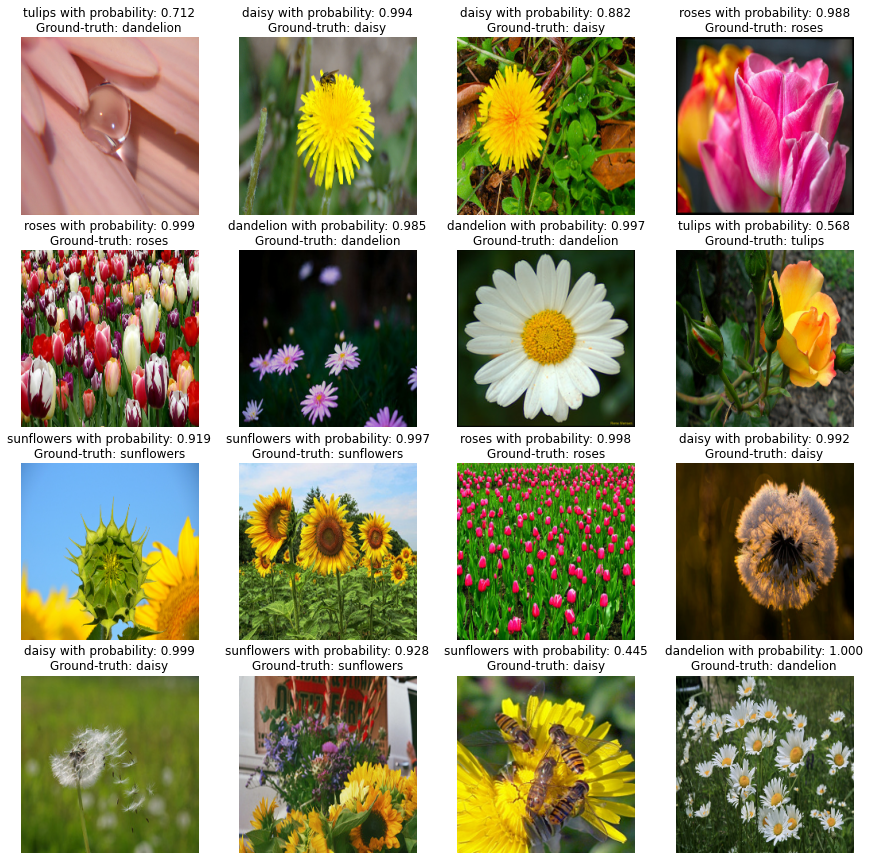

In [14]:
# Let's run inference on a batch of images from the validation set
(batch_images, batch_labels) = next(iter(validation_ds))
predictions = model_mnv2.predict(batch_images)
plot_predictions(batch_images[:16], batch_labels[:16], predictions[:16])

Let's take a sample for which our model is very confident about the prediction it has made. The crossentropy loss for this sample has to be very low. 

In [15]:
cce = tf.keras.losses.SparseCategoricalCrossentropy()
loss = cce(
    batch_labels[-1],
    predictions[-1]
)
print("Crossentropy loss: ",loss.numpy())

# The probability we got when we ran the inference
print("Class probability: ",np.exp(-loss.numpy()))

Crossentropy loss:  0.15954748
Class probability:  0.85252947


## Creating adversarial examples to fool the above image classifier

In [16]:
# Clipping utility so that the pixel values stay within [0,1]
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [17]:
def generate_adversaries_targeted(model, image_tensor, delta, 
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = (image_tensor + delta)/255.
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [18]:
def perturb_image(model, image, true, target):
    print("Before adversarial attack")
    preprocessed_image = image/255.
    probabilities = model.predict(preprocessed_image)
    class_index = np.argmax(probabilities)
    print("Ground-truth label: {} predicted label: {}".format(CLASSES[true], CLASSES[class_index]))
    
    # Initialize the perturbation quantity
    image_tensor = tf.constant(image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(model, image_tensor, delta, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = (image_tensor + delta_tensor)/255.
    print("After adversarial attack")
    
    # Generate predictions
    preds = model.predict(perturbed_image)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Predicted label: {}".format(pred_label))
    cv2.imwrite("perturbed_image.png", perturbed_image.numpy().squeeze())

Let's fool the classifier by making it believe that an image of a **dandelion (index 1)** is of a **tulips (index 4)**. 

Before adversarial attack
Ground-truth label: dandelion predicted label: dandelion
0 12.532771
20 9.974243
40 8.003115
60 6.2977886
80 4.7968225
100 3.3704844
120 1.8760883
140 0.4578197
160 -0.8292651
180 -2.0790222
200 -3.2445376
220 -4.3715315
240 -5.4959626
260 -6.583101
280 -7.600794
300 -8.579015
320 -9.475353
340 -10.273779


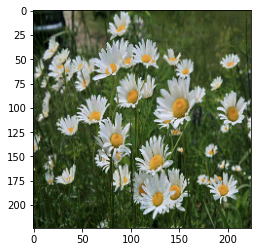

After adversarial attack
Predicted label: tulips


In [19]:
# Let's see this in action
index = 15
sample_val_image = (batch_images[index].numpy()*255).astype(np.uint8)
sample_val_image = np.expand_dims(sample_val_image, 0)
perturb_image(model_mnv2, sample_val_image, batch_labels[index].numpy(), 4)

## Adversarial training with `nsl`

In [20]:
# Setup Neural Structured Learning
!pip install -q neural-structured-learning
import neural_structured_learning as nsl

     |████████████████████████████████| 122kB 9.2MB/s 


NSL expects the data to be present in a slightly different format than what Keras would expect. So, we need to make the changes accordingly.

In [21]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, SIZE)
    return {"image": image, "label": label}

# Construct TensorFlow dataset
train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

- `adv_multiplier`: The weight of adversarial loss in the training objective, relative to the labeled loss.
- `adv_step_size`: The magnitude of adversarial perturbation.
- `adv_grad_norm`: The norm to measure the magnitude of adversarial perturbation.

In [22]:
# Configuration for adversarial training
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=0.3,
    adv_step_size=0.1,
    adv_grad_norm="infinity"
)

In [23]:
# This time we are not training the base model
base_model = MobileNetV2(weights="imagenet", include_top=False,
        input_shape=(224, 224, 3))
base_model.trainable = False
base_adv_model = get_training_model(base_model)
base_adv_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
# Create and compile the adv. model
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    adv_config=adv_config
)

adv_model.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

# Train the model
start = time.time()
h = adv_model.fit(train_ds,
                  validation_data=validation_ds,
                  epochs=5)
print("Total training time (seconds): ",time.time()-start)

Epoch 1/5


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7efcf58c6e58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7efcf58c6e58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7efcf58c6e58> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


     49/Unknown - 10s 203ms/step - loss: 1.4717 - sparse_categorical_crossentropy: 0.9349 - sparse_categorical_accuracy: 0.6574 - scaled_adversarial_loss: 0.5369WARNING:tensorflow:The dtype of the watched tensor must be floating (e.g. tf.float32), got tf.int64


49/49 [==============================] - 14s 281ms/step - loss: 1.4717 - sparse_categorical_crossentropy: 0.9349 - sparse_categorical_accuracy: 0.6574 - scaled_adversarial_loss: 0.5369 - val_loss: 1.0368 - val_sparse_categorical_crossentropy: 0.5600 - val_sparse_categorical_accuracy: 0.8218 - val_scaled_adversarial_loss: 0.4768
Epoch 2/5
49/49 [==============================] - 11s 234ms/step - loss: 0.9358 - sparse_categorical_crossentropy: 0.4877 - sparse_categorical_accuracy: 0.8401 - scaled_adversarial_loss: 0.4480 - val_loss: 0.8672 - val_sparse_categorical_crossentropy: 0.4355 - val_sparse_categorical_accuracy: 0.8527 - val_scaled_adversarial_loss: 0.4317
Epoch 3/5
49/49 [==============================] - 11s 234ms/step - loss: 0.8226 - sparse_categorical_crossentropy: 0.4044 - sparse_categorical_accuracy: 0.8699 - scaled_adversarial_loss: 0.4182 - val_loss: 0.7996 - val_sparse_categorical_crossentropy: 0.3892 - val_sparse_categorical_accuracy: 0.8673 - val_scaled_adversarial_los

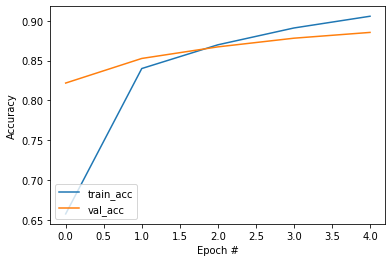

In [25]:
N = len(h.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), h.history["sparse_categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), h.history["val_sparse_categorical_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

The accuracy of this model is not anywhere near our previous model's accuracy. Now, we will test the robustness of the above two models under adversarial perturbations as shown in [this tutorial](https://www.tensorflow.org/neural_structured_learning/tutorials/adversarial_keras_cnn_mnist#robustness_under_adversarial_perturbations). Most of the code below comes from that tutorial itself. 

In [26]:
# Compile the base model after wrapping it with `AdversarialRegularization`
# Needed to generate perturbated samples
reference_model = nsl.keras.AdversarialRegularization(
    model_mnv2,
    adv_config=adv_config)
reference_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

In [27]:
# Models to be evaluated
models_to_eval = {
    'base': model_mnv2,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [37]:
# Comes from the above-mentioned tutorial with some modification
perturbed_images, labels, predictions = [], [], []

for batch in validation_ds:
    perturbed_batch = reference_model.perturb_on_batch(batch)
    # Clipping makes perturbed examples have the same range as regular ones.
    perturbed_batch["image"] = tf.clip_by_value(                          
        perturbed_batch["image"], 0.0, 1.0)
    y_true = perturbed_batch.pop("label")
    perturbed_images.append(perturbed_batch["image"].numpy())
    labels.append(y_true.numpy())
    predictions.append({})
    for name, model in models_to_eval.items():
        y_pred = model(perturbed_batch)
        metrics[name](y_true, y_pred)
        predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
    print('%s model accuracy: %f' % (name, metric.result().numpy()))

base model accuracy: 0.275244
adv-regularized model accuracy: 0.565147


With more training, adversarial model's performance could be improved. 

accuracy in batch 1:
base model: 11 / 32
adv-regularized model: 17 / 32


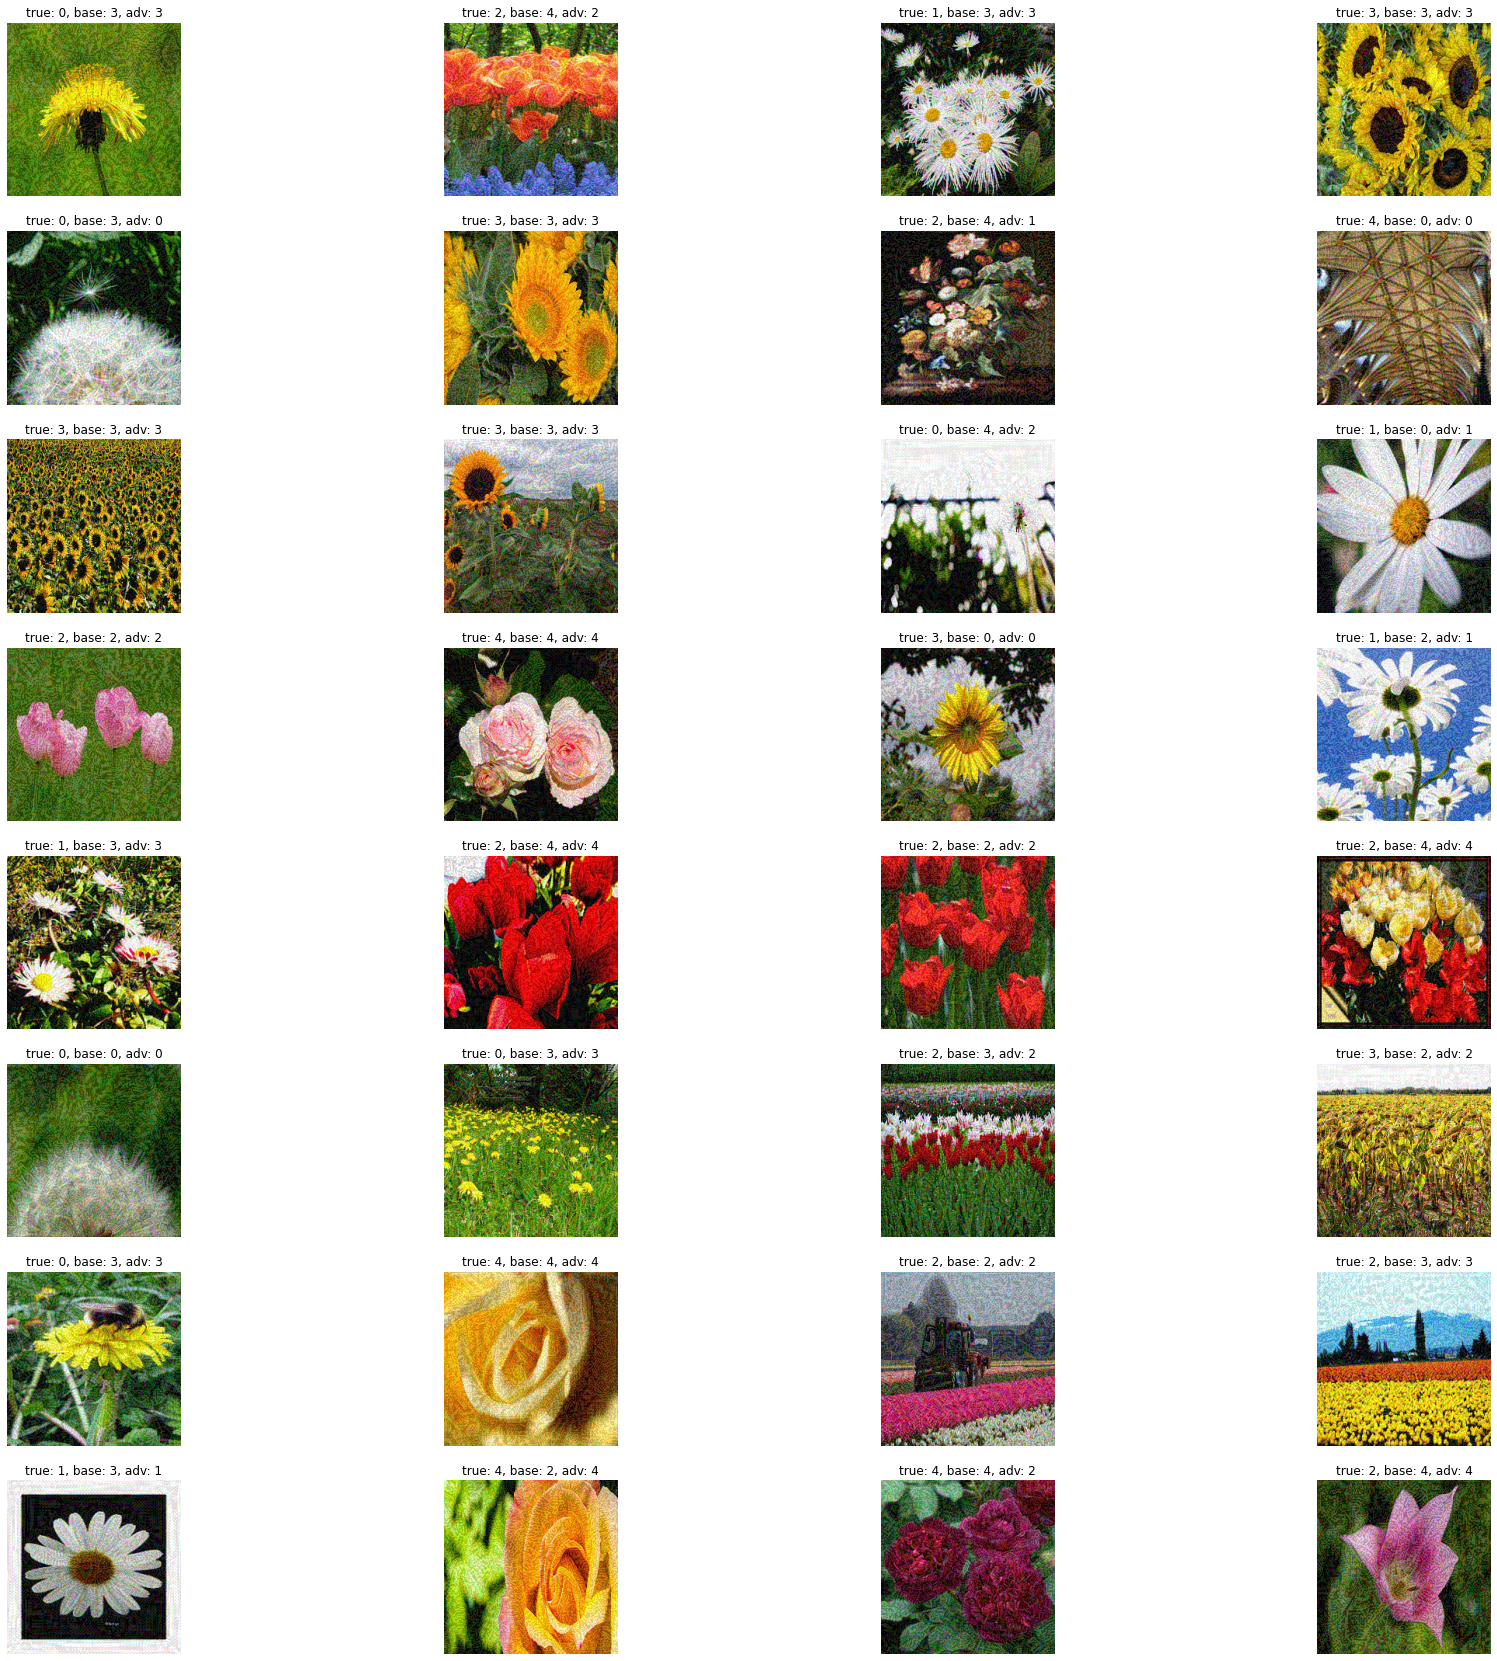

In [70]:
# Comes from the above-mentioned tutorial with some modification
batch_index = 1 # Change as needed

batch_image = perturbed_images[batch_index][:32]
batch_label = labels[batch_index][:32]
batch_pred = predictions[batch_index]

batch_size = 32
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
    print('%s model: %d / %d' % (name, np.sum(batch_label == pred[:32]), batch_size))

plt.figure(figsize=(30, 30))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
    y_base = batch_pred['base'][i]
    y_adv = batch_pred['adv-regularized'][i]
    # y = np.argmax(y)
    plt.subplot(n_row, n_col, i+1)
    plt.title('true: {}, base: {}, adv: {}'.format(y, y_base, y_adv))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis('off')

plt.show()